Огородников Николай Александрович, группа 191-321

# Task 4.

### Цель работы:

1. Научиться моделировать такие временные ряды с помощью нейросетевых моделей, как AR, AR(X).
2. Найти достаточное количество скрытых слоев и количество нейронов в сети для обучения в задачах аппроксимации математических функций.
3. Произвести оценку полученных результатов на тестовой выборке.

### Задание 1.
Реализовать и протестировать AR-модель на функции $\sin\left(\[\frac{x}{2}\]\right)$.

         sinX
0    0.000000
1    0.479426
2    0.841471
3    0.997495
4    0.909297
..        ...
196 -0.573382
197 -0.895978
198 -0.999207
199 -0.857795
200 -0.506366

[201 rows x 1 columns]
         sinX
200 -0.506366
201 -0.030960
202  0.452026
203  0.824340
204  0.994827
205  0.921745
206  0.622989
207  0.171702
208 -0.321622
209 -0.736203
210 -0.970535
211 -0.967247
212 -0.727143
213 -0.309008
214  0.184782
215  0.633331
216  0.926819
217  0.993389
218  0.816743
219  0.440129
220 -0.044243
221 -0.517783
222 -0.864551
223 -0.999648
224 -0.889996
225 -0.562441
226 -0.097182
227  0.391871
228  0.784980
229  0.985899
230  0.945435
231  0.673496
232  0.236661
233 -0.258116
234 -0.689698
235 -0.952418
236 -0.981952
237 -0.771071
238 -0.371404
239  0.119195
240  0.580611
241  0.899873
242  0.998815
243  0.853212
244  0.498713
245  0.022112
246 -0.459903
247 -0.829318
248 -0.995687
249 -0.918277


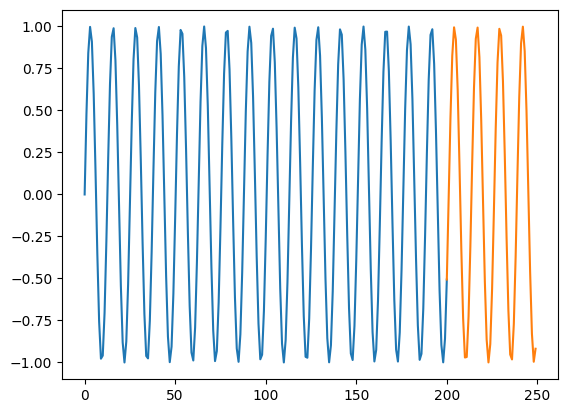

In [156]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# создание обучающей выборки
x_train = np.arange(0, 201, 1)
y_train = [math.sin(a / 2) for a in x_train]

df_train = pd.DataFrame(y_train, index=x_train, columns=['sinX'])

print(df_train)

# создание тестовой выборки
x_test = np.arange(200, 250, 1)
y_test = [math.sin(a / 2) for a in x_test]

df_test = pd.DataFrame(y_test, index=x_test, columns=['sinX'])

print(df_test)

# вывод точек обучающей выборки
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.show()

In [157]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# модель полносвязного слоя нейронной сети
class DenseNN(tf.Module):
    # конструктор
    # outputs - количество нейронов (выходов) с полносвязного слоя
    def __init__(self, outputs):
        super().__init__()  # конструктор базового класса
        self.outputs = outputs  # сохранение количества нейронов
        self.fl_init = False  # флаг проведения инициализации

    # делает из класса функтор
    # x - вектор входных параметров
    def __call__(self, x):
        # начальные значения весовых параметров
        if not self.fl_init:
            # скрытые слои
            # случайная нормальная величина
            self.w1 = tf.Variable(
                tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w1"))
            self.b1 = tf.Variable(tf.zeros([self.outputs], dtype=tf.float32, name="b1"))  # вектор смещения

            # self.w2 = tf.Variable(tf.random.truncated_normal((self.outputs, self.outputs), stddev=0.1, name="w2"))
            # self.b2 = tf.Variable(tf.zeros([self.outputs], dtype=tf.float32, name="b2"))
            #
            # self.w3 = tf.Variable(tf.random.truncated_normal((self.outputs, self.outputs), stddev=0.1, name="w3"))
            # self.b3 = tf.Variable(tf.zeros([self.outputs], dtype=tf.float32, name="b3"))

            # выходной слой
            self.w4 = tf.Variable(
                tf.random.truncated_normal((self.outputs, 1), stddev=0.1, name="w4", dtype=tf.float32))
            self.b4 = tf.Variable(tf.zeros([1], dtype=tf.float32, name="b4"))

            # предотвращаем повторную инициализацию
            self.fl_init = True

        # вычисляем выходное значение
        # для скрытого слоя - гиперболический тангенс
        # для выходного - линейная
        # y = tf.nn.tanh(tf.nn.tanh(x @ self.w1 + self.b1) @ self.w2 + self.b2) @ self.w4 + self.b4
        y = tf.nn.tanh(x @ self.w1 + self.b1) @ self.w4 + self.b4
        return y

In [158]:
import tensorflow as tf
import numpy as np

model = DenseNN(4)

# функция потерь
loss = lambda x, y: tf.reduce_mean(tf.square(x - y))  # квадрат рассогласования между требуемым и получившимся выходом
opt = tf.optimizers.Adam(learning_rate=0.005)  # оптимизатор для градиентного спуска

inp_items = 3 # количество предыдущих значений для обучения
n = df_train.shape[0] - inp_items
X = np.squeeze(np.array([df_train[i:i + inp_items] for i in range(n)])) # создание выборок типа [[1 2 3] [2 3 4] [3 4 5]]
Y = df_train[inp_items:].sinX # берем значения, начиная с inp_items + 1

EPOCHS = 4  # количество итераций алгоритма
for n in range(EPOCHS):
    # перебор обучающего множества
    for x, y in zip(X, Y):
        x = tf.expand_dims(x, axis=0)  # преобразование в матрицу 1 на количество наблюдений
        x = tf.cast(x, dtype=tf.float32)
        y = tf.constant(y, shape=(1, 1))  # преобразование в матрицу 1 на 1

        with tf.GradientTape() as tape:
            f_loss = loss(y, model(x))

        # вычисление градиентов по всем обучаемым параметрам модели
        grads = tape.gradient(f_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))

    print(EPOCHS - n, ' ', f_loss.numpy())

4   0.00036458045
3   0.00033793785
2   0.0003290105
1   0.00031590398


tf.Tensor(
[[ 0.8297371 ]
 [ 0.9797959 ]
 [ 0.9143008 ]
 [ 0.6371513 ]
 [ 0.18078679]
 [-0.33627647]
 [-0.7475505 ]
 [-0.9575834 ]
 [-0.9525646 ]
 [-0.73591983]
 [-0.32470235]
 [ 0.19172038]
 [ 0.6489802 ]
 [ 0.9215941 ]
 [ 0.97763103]
 [ 0.8196027 ]
 [ 0.45663008]
 [-0.04607014]
 [-0.5357462 ]
 [-0.8652317 ]
 [-0.9815244 ]
 [-0.88445675]
 [-0.5785937 ]
 [-0.10482317]
 [ 0.40694207]
 [ 0.7934335 ]
 [ 0.97239107]
 [ 0.9352881 ]
 [ 0.68565035]
 [ 0.2484202 ]
 [-0.27040377]
 [-0.70357233]
 [-0.9421825 ]
 [-0.96544963]
 [-0.7766935 ]
 [-0.38833344]
 [ 0.12280102]
 [ 0.59724945]
 [ 0.89784384]
 [ 0.98256713]
 [ 0.8528244 ]
 [ 0.5152482 ]
 [ 0.02381208]
 [-0.477641  ]
 [-0.83350277]
 [-0.97846377]
 [-0.9095358 ]], shape=(47, 1), dtype=float32)


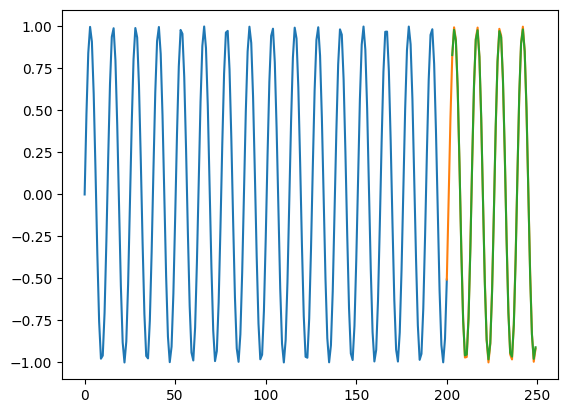

In [159]:
# проверка на тестовой выборке
import numpy as np
import matplotlib.pyplot as plt

k = df_test.shape[0] - inp_items

X_test = np.squeeze(np.array([df_test[i:i + inp_items] for i in range(k)]))
Y_test = df_test[inp_items:]

Y_pred = model(X_test)

print(Y_pred)

plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(Y_test.index, Y_pred)
plt.show()

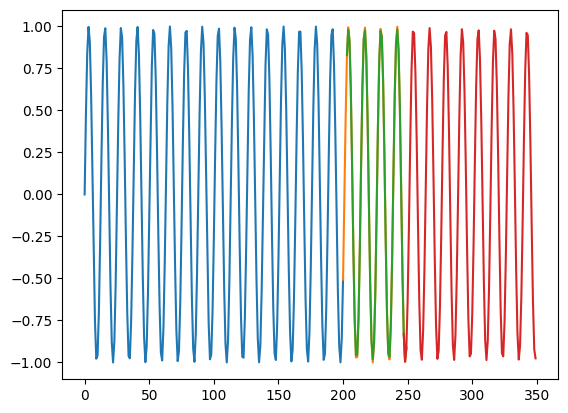

In [160]:
# прогнозирование
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Y_future = df_test[-inp_items:]
iterations = 100

for i in range(iterations):
    X_future = np.array([Y_future[-inp_items:].sinX])
    result = pd.DataFrame(model(X_future), index=[Y_future.index[-1] + 1], columns=['sinX'])

    Y_future = pd.concat((Y_future, result))

plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(Y_test.index, Y_pred)
plt.plot(Y_future.index, Y_future.sinX)
plt.show()



### Вывод

В рамках задания был реализован временной ряд нейросетевой модели AR.

В ходе решения были сформированы обучающие и тестовые выборки для функции $\sin\left(\[\frac{x}{2}\]\right)$ на промежутке от 0 до 200 и от 200 до 250 соответственно с шагом в 1. Далее с помощью библиотеки tensorflow была реализована и обучена AR модель нейронной сети. Затем в качестве проверки на графике были выведены графики с предсказанием исходной функции на фоне тестовой выборки, а затем самостоятельное прогнозирование.
